# ML Assignment 7: Principal Component Analysis (PCA) on Churn Dataset

## Objective
Apply Principal Component Analysis (PCA) for dimensionality reduction on customer churn data. Analyze how PCA parameters (n_components, svd_solver, whiten) affect model performance and data transformation. Compare Decision Tree classifier performance on original features versus PCA-transformed features, and visualize variance explanation, component loadings, and data projections to understand feature importance and relationships.

---

## Step 1: Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 2: Load and Explore the Dataset

In [39]:
# Load the dataset
df = pd.read_csv('churn_dataset.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Variable Distribution:")
print(df['Churn'].value_counts())

Dataset Shape: (7043, 21)

First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Strea

### 2.1 Detailed Data Exploration

In [40]:
# Detailed exploration of the dataset
print("="*80)
print("DETAILED DATA EXPLORATION")
print("="*80)

print("\n1. Dataset Dimensions:")
print(f"   - Number of rows: {df.shape[0]:,}")
print(f"   - Number of columns: {df.shape[1]}")

print("\n2. Data Types Summary:")
print(df.dtypes.value_counts())

print(f"\n3. Duplicate Rows: {df.duplicated().sum()}")

print("\n4. Missing Values Analysis:")
missing = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("   No missing values detected initially!")

print("\n5. TotalCharges Column Analysis:")
print(f"   - Data Type: {df['TotalCharges'].dtype}")
print(f"   - Sample values: {df['TotalCharges'].head(10).tolist()}")

# Check for non-numeric values in TotalCharges
try:
    # Try to convert to numeric - this will reveal any issues
    total_charges_numeric = pd.to_numeric(df['TotalCharges'], errors='coerce')
    non_numeric_count = total_charges_numeric.isnull().sum() - df['TotalCharges'].isnull().sum()
    print(f"   - Non-numeric values found: {non_numeric_count}")
    if non_numeric_count > 0:
        print(f"   - These are likely spaces ' ' or empty strings that need conversion!")
except:
    print("   - Unable to analyze TotalCharges for non-numeric values")

print("\n6. Numerical Features Statistics:")
print(df.describe())

print("\n7. Categorical Features:")
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print(f"   Total categorical features: {len(categorical_features)}")
print(f"   Features: {categorical_features}")

print("\n8. Target Variable (Churn) Distribution:")
churn_counts = df['Churn'].value_counts()
churn_percent = df['Churn'].value_counts(normalize=True) * 100
print(f"   - No:  {churn_counts.get('No', 0):,} ({churn_percent.get('No', 0):.2f}%)")
print(f"   - Yes: {churn_counts.get('Yes', 0):,} ({churn_percent.get('Yes', 0):.2f}%)")
print(f"   - Class Imbalance Ratio: {churn_counts.max() / churn_counts.min():.2f}:1")

print("\n9. Unique Values in Categorical Features:")
for col in categorical_features[:10]:  # Show first 10
    unique_count = df[col].nunique()
    print(f"   - {col}: {unique_count} unique values")

print("\n" + "="*80)

DETAILED DATA EXPLORATION

1. Dataset Dimensions:
   - Number of rows: 7,043
   - Number of columns: 21

2. Data Types Summary:
object     18
int64       2
float64     1
Name: count, dtype: int64

3. Duplicate Rows: 0

4. Missing Values Analysis:
   No missing values detected initially!

5. TotalCharges Column Analysis:
   - Data Type: object
   - Sample values: ['29.85', '1889.5', '108.15', '1840.75', '151.65', '820.5', '1949.4', '301.9', '3046.05', '3487.95']
   - Non-numeric values found: 11
   - These are likely spaces ' ' or empty strings that need conversion!

6. Numerical Features Statistics:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.

## Step 3: Data Preprocessing

### 3.1 Handle Missing Values and Data Cleaning

In [41]:
# Handle TotalCharges - it appears numeric but contains spaces ' ' for some customers with 0 tenure
# These spaces cannot be used in calculations, so we convert to numeric (coerce turns invalid values to NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many missing values we now have
print(f"Missing values in TotalCharges after conversion: {df['TotalCharges'].isnull().sum()}")

# Fill missing TotalCharges with median (reasonable since they're likely new customers)
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop customerID as it's not useful for prediction
df = df.drop('customerID', axis=1)

print("\nData cleaned successfully!")
print(f"Remaining missing values: {df.isnull().sum().sum()}")
print(f"Final dataset shape: {df.shape}")

Missing values in TotalCharges after conversion: 11

Data cleaned successfully!
Remaining missing values: 0
Final dataset shape: (7043, 20)


### 3.2 Encode Categorical Variables

In [ ]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
#label encoding
# Encode binary categorical variables (Yes/No, Male/Female)
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

# One-hot encode multi-category variables
multi_cat_cols = [col for col in categorical_cols if col not in binary_cols]
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

print(f"\nDataset shape after encoding: {df.shape}")
print(df.head())

Categorical columns (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

Dataset shape after encoding: (7043, 31)
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1           29.85         29.85      0  ...   
1                 0           56.95       1889.50      0  ...   
2                 1           53.85        108.15      1  ...

## Step 4: Feature Selection and Train-Test Split

In [43]:

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


print(f"Scaled Features shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts(normalize=True))

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=52, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Scaled Features shape: (7043, 30)
Target shape: (7043,)

Class distribution:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Training set size: 5634
Test set size: 1409


## Step 5: Decision Tree Implementation

### 5.1 Train Basic Decision Tree Model

In [44]:
# Create and train Decision Tree model with default parameters
dt_model = DecisionTreeClassifier(random_state=52)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

print("Decision Tree model trained successfully!")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")

Decision Tree model trained successfully!
Tree depth: 27
Number of leaves: 1102


### 5.2 Evaluate Basic Decision Tree Performance

In [45]:
# Calculate metrics
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_auc = roc_auc_score(y_test, y_pred_proba_dt)

print("=" * 50)
print("DECISION TREE PERFORMANCE (Default Parameters)")
print("=" * 50)
print(f"Accuracy:  {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall:    {dt_recall:.4f}")
print(f"F1-Score:  {dt_f1:.4f}")
print(f"ROC-AUC:   {dt_auc:.4f}")
print("=" * 50)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn']))

DECISION TREE PERFORMANCE (Default Parameters)
Accuracy:  0.7282
Precision: 0.4885
Recall:    0.5107
F1-Score:  0.4993
ROC-AUC:   0.6591

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.82      0.81      0.81      1035
       Churn       0.49      0.51      0.50       374

    accuracy                           0.73      1409
   macro avg       0.65      0.66      0.66      1409
weighted avg       0.73      0.73      0.73      1409



### 5.3 Decision Tree Confusion Matrix

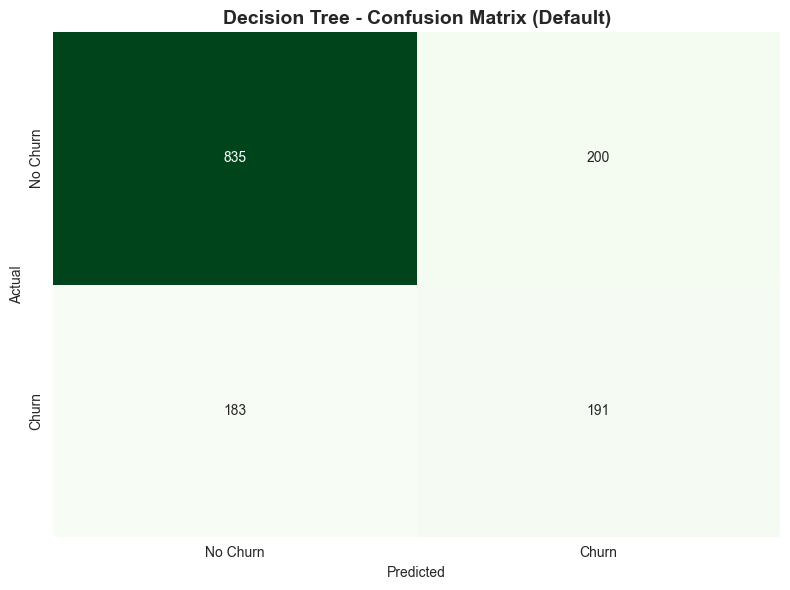

In [46]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Decision Tree - Confusion Matrix (Default)', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

## Step 6: Visualize Decision Tree

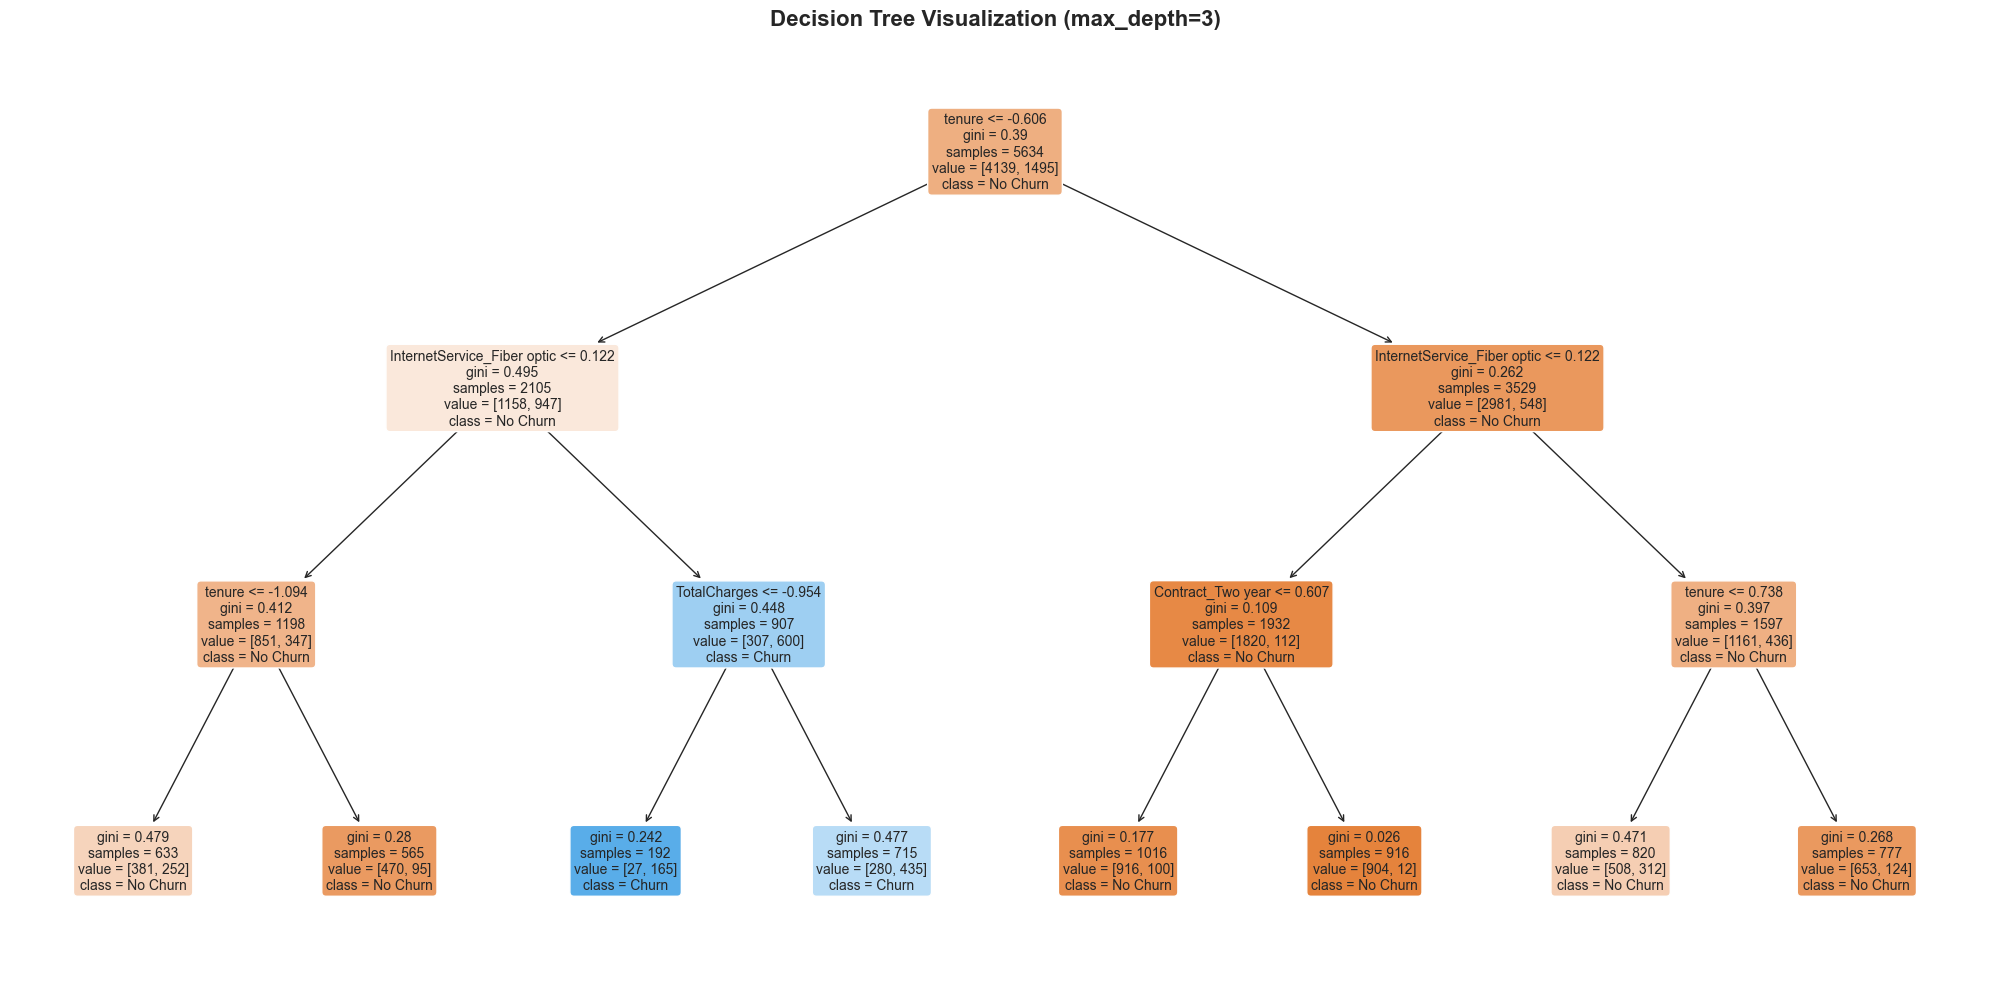

In [47]:
# Visualize a simplified version of the tree (max_depth=3 for visibility)
dt_simple = DecisionTreeClassifier(max_depth=3, random_state=52)
dt_simple.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt_simple, 
          feature_names=X.columns,
          class_names=['No Churn', 'Churn'],
          filled=True,
          fontsize=10,
          rounded=True)
plt.title('Decision Tree Visualization (max_depth=3)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 7: Apply PCA (Principal Component Analysis)

### 7.1 Import PCA and Analyze Variance

In [48]:
from sklearn.decomposition import PCA

# First, let's analyze the explained variance to determine optimal number of components
# Fit PCA with all components to see variance distribution
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate cumulative explained variance
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Display variance information
print("=" * 60)
print("PCA VARIANCE ANALYSIS")
print("=" * 60)
print(f"Original number of features: {X_scaled.shape[1]}")
print(f"\nTop 10 components and their explained variance:")
for i in range(min(10, len(explained_variance_ratio))):
    print(f"  PC{i+1}: {explained_variance_ratio[i]:.4f} ({explained_variance_ratio[i]*100:.2f}%)")

# Find number of components for different variance thresholds
for threshold in [0.80, 0.85, 0.90, 0.95, 0.99]:
    n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
    print(f"\nComponents needed for {threshold*100:.0f}% variance: {n_components}")
    print(f"  Cumulative variance: {cumulative_variance_ratio[n_components-1]:.4f}")

print("=" * 60)

PCA VARIANCE ANALYSIS
Original number of features: 30

Top 10 components and their explained variance:
  PC1: 0.3318 (33.18%)
  PC2: 0.1199 (11.99%)
  PC3: 0.0902 (9.02%)
  PC4: 0.0475 (4.75%)
  PC5: 0.0415 (4.15%)
  PC6: 0.0412 (4.12%)
  PC7: 0.0381 (3.81%)
  PC8: 0.0334 (3.34%)
  PC9: 0.0312 (3.12%)
  PC10: 0.0295 (2.95%)

Components needed for 80% variance: 10
  Cumulative variance: 0.8043

Components needed for 85% variance: 12
  Cumulative variance: 0.8546

Components needed for 90% variance: 15
  Cumulative variance: 0.9179

Components needed for 95% variance: 17
  Cumulative variance: 0.9510

Components needed for 99% variance: 20
  Cumulative variance: 0.9901


### 7.2 Visualize Explained Variance

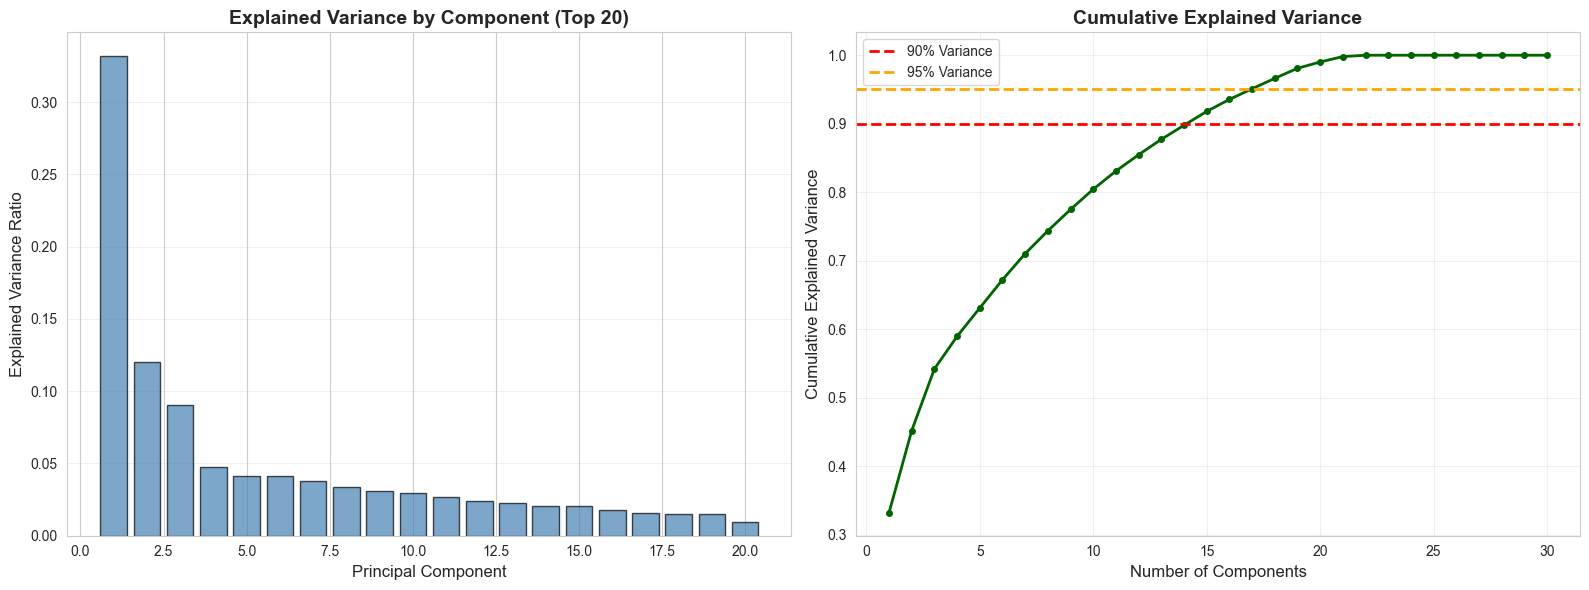

In [49]:
# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Individual explained variance
axes[0].bar(range(1, min(21, len(explained_variance_ratio)+1)), 
            explained_variance_ratio[:20], 
            alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Explained Variance by Component (Top 20)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance_ratio)+1), 
             cumulative_variance_ratio, 
             marker='o', linewidth=2, color='darkgreen', markersize=4)
axes[1].axhline(y=0.90, color='r', linestyle='--', label='90% Variance', linewidth=2)
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% Variance', linewidth=2)
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 7.3 Apply PCA with Optimal Components (95% Variance)

In [50]:
# Apply PCA with 95% variance threshold
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

pca = PCA(n_components=n_components_95, random_state=52)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("=" * 60)
print("PCA TRANSFORMATION RESULTS")
print("=" * 60)
print(f"Original feature dimensions: {X_train.shape[1]}")
print(f"Reduced feature dimensions: {X_train_pca.shape[1]}")
print(f"Dimensionality reduction: {(1 - X_train_pca.shape[1]/X_train.shape[1])*100:.2f}%")
print(f"\nTotal variance explained: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")
print(f"\nTransformed training data shape: {X_train_pca.shape}")
print(f"Transformed test data shape: {X_test_pca.shape}")
print("=" * 60)

PCA TRANSFORMATION RESULTS
Original feature dimensions: 30
Reduced feature dimensions: 17
Dimensionality reduction: 43.33%

Total variance explained: 0.9507 (95.07%)

Transformed training data shape: (5634, 17)
Transformed test data shape: (1409, 17)


### 7.4 Train Decision Tree on PCA-Transformed Data

In [51]:
# Train Decision Tree on PCA-transformed data
dt_pca_model = DecisionTreeClassifier(random_state=52)
dt_pca_model.fit(X_train_pca, y_train)

# Make predictions
y_pred_dt_pca = dt_pca_model.predict(X_test_pca)
y_pred_proba_dt_pca = dt_pca_model.predict_proba(X_test_pca)[:, 1]

# Calculate metrics
dt_pca_accuracy = accuracy_score(y_test, y_pred_dt_pca)
dt_pca_precision = precision_score(y_test, y_pred_dt_pca)
dt_pca_recall = recall_score(y_test, y_pred_dt_pca)
dt_pca_f1 = f1_score(y_test, y_pred_dt_pca)
dt_pca_auc = roc_auc_score(y_test, y_pred_proba_dt_pca)

print("=" * 60)
print("DECISION TREE PERFORMANCE (with PCA)")
print("=" * 60)
print(f"Accuracy:  {dt_pca_accuracy:.4f}")
print(f"Precision: {dt_pca_precision:.4f}")
print(f"Recall:    {dt_pca_recall:.4f}")
print(f"F1-Score:  {dt_pca_f1:.4f}")
print(f"ROC-AUC:   {dt_pca_auc:.4f}")
print("=" * 60)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt_pca, target_names=['No Churn', 'Churn']))

DECISION TREE PERFORMANCE (with PCA)
Accuracy:  0.7317
Precision: 0.4949
Recall:    0.5187
F1-Score:  0.5065
ROC-AUC:   0.6671

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.82      0.81      0.82      1035
       Churn       0.49      0.52      0.51       374

    accuracy                           0.73      1409
   macro avg       0.66      0.66      0.66      1409
weighted avg       0.74      0.73      0.73      1409



### 7.5 Compare Performance: Original vs PCA-Transformed Data

PERFORMANCE COMPARISON: Original vs PCA-Transformed Data
   Metric  Original Data  PCA Data  Difference
 Accuracy       0.728176  0.731725    0.003549
Precision       0.488491  0.494898    0.006407
   Recall       0.510695  0.518717    0.008021
 F1-Score       0.499346  0.506527    0.007181
  ROC-AUC       0.659100  0.667106    0.008006


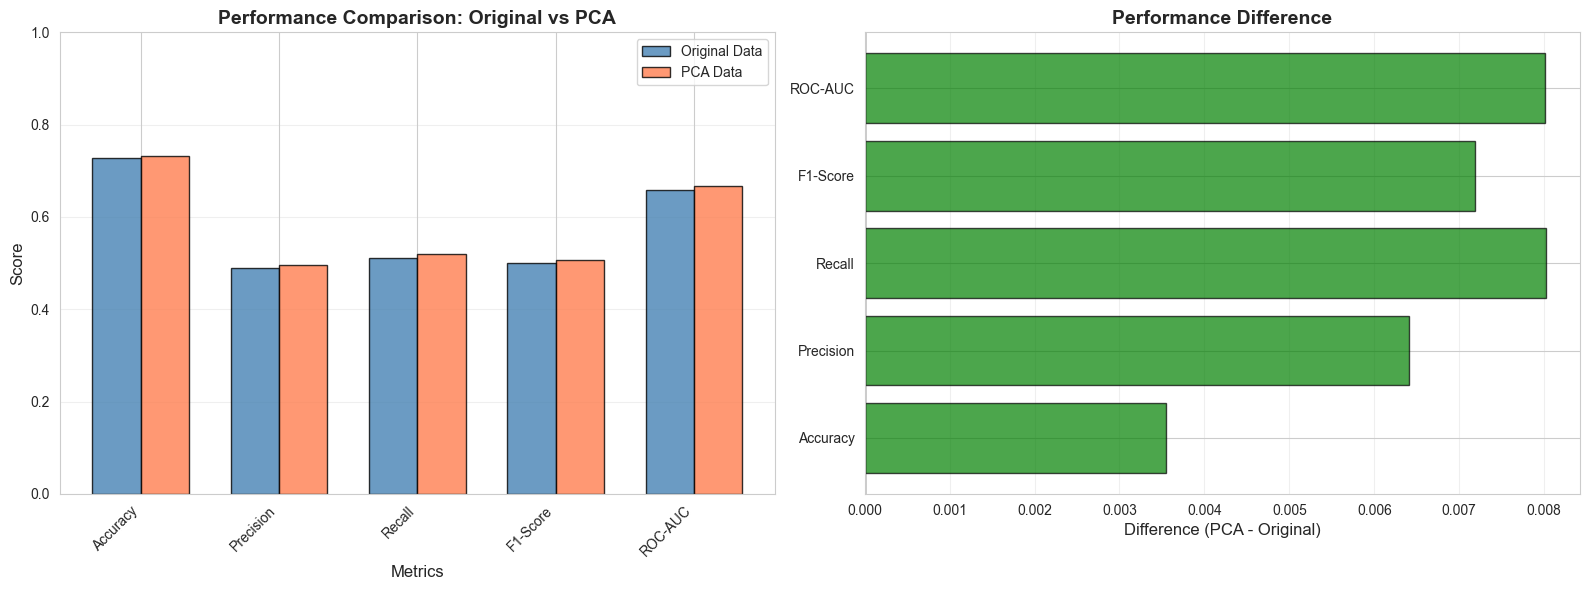

In [52]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Original Data': [dt_accuracy, dt_precision, dt_recall, dt_f1, dt_auc],
    'PCA Data': [dt_pca_accuracy, dt_pca_precision, dt_pca_recall, dt_pca_f1, dt_pca_auc]
})
comparison_df['Difference'] = comparison_df['PCA Data'] - comparison_df['Original Data']

print("=" * 70)
print("PERFORMANCE COMPARISON: Original vs PCA-Transformed Data")
print("=" * 70)
print(comparison_df.to_string(index=False))
print("=" * 70)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
x_pos = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x_pos - width/2, comparison_df['Original Data'], width, 
            label='Original Data', alpha=0.8, color='steelblue', edgecolor='black')
axes[0].bar(x_pos + width/2, comparison_df['PCA Data'], width, 
            label='PCA Data', alpha=0.8, color='coral', edgecolor='black')
axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Comparison: Original vs PCA', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Metric'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Difference plot
colors = ['green' if x >= 0 else 'red' for x in comparison_df['Difference']]
axes[1].barh(comparison_df['Metric'], comparison_df['Difference'], 
             color=colors, alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Difference (PCA - Original)', fontsize=12)
axes[1].set_title('Performance Difference', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 7.6 Visualize PCA Components (2D Projection)

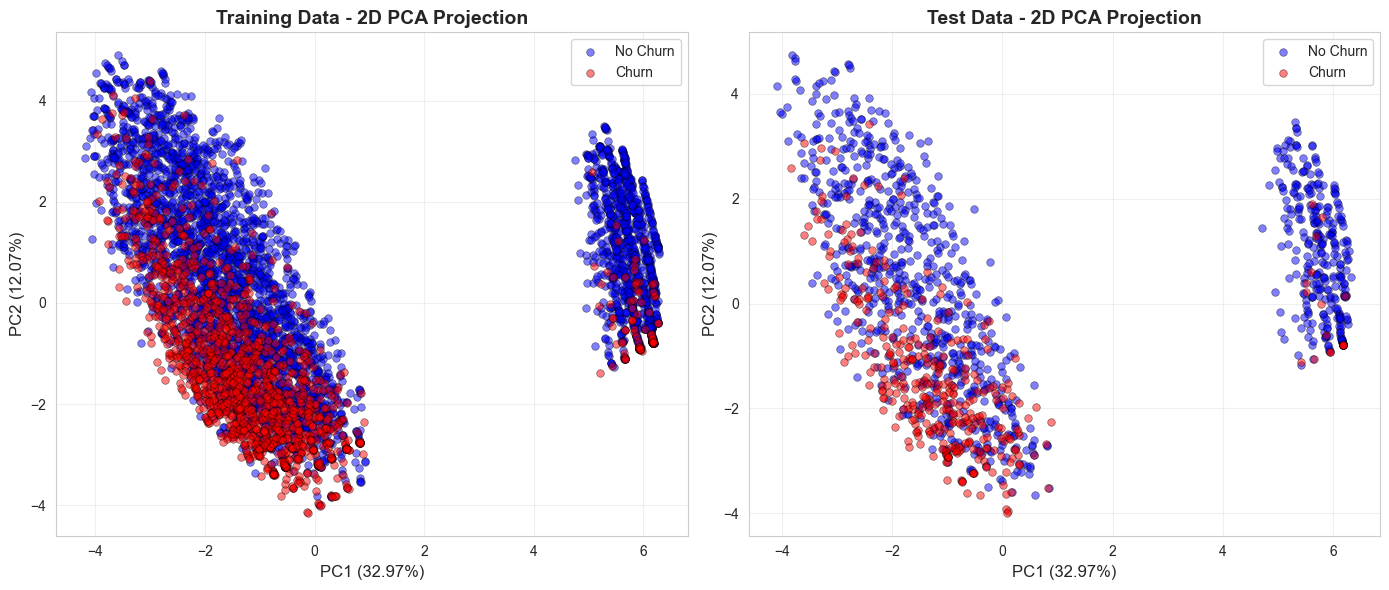


Total variance explained by 2 components: 45.05%


In [53]:
# Create 2D PCA for visualization
pca_2d = PCA(n_components=2, random_state=52)
X_train_2d = pca_2d.fit_transform(X_train)
X_test_2d = pca_2d.transform(X_test)

# Plot 2D PCA projection
plt.figure(figsize=(14, 6))

# Training data
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_train_2d[y_train==0, 0], X_train_2d[y_train==0, 1], 
                       c='blue', alpha=0.5, s=30, edgecolors='k', linewidth=0.5, label='No Churn')
scatter2 = plt.scatter(X_train_2d[y_train==1, 0], X_train_2d[y_train==1, 1], 
                       c='red', alpha=0.5, s=30, edgecolors='k', linewidth=0.5, label='Churn')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12)
plt.title('Training Data - 2D PCA Projection', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Test data
plt.subplot(1, 2, 2)
scatter3 = plt.scatter(X_test_2d[y_test==0, 0], X_test_2d[y_test==0, 1], 
                       c='blue', alpha=0.5, s=30, edgecolors='k', linewidth=0.5, label='No Churn')
scatter4 = plt.scatter(X_test_2d[y_test==1, 0], X_test_2d[y_test==1, 1], 
                       c='red', alpha=0.5, s=30, edgecolors='k', linewidth=0.5, label='Churn')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12)
plt.title('Test Data - 2D PCA Projection', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal variance explained by 2 components: {pca_2d.explained_variance_ratio_.sum()*100:.2f}%")

## Step 8: PCA Parameter Experimentation

### 8.1 Experiment with n_components Parameter

In [54]:
"""
EXPERIMENT 1: n_components Parameter
=====================================
This parameter controls how many principal components to keep.
- Integer: Keeps exactly that many components
- Float (0.0 to 1.0): Keeps enough components to retain that percentage of variance
- None: Keeps all components
- 'mle': Uses Minka's MLE to guess the optimal number

Impact: More components = more variance explained but higher dimensionality
"""

# Test different n_components values
n_components_experiments = [2, 5, 10, 15, 0.80, 0.90, 0.95, 0.99]
results_n_components = []

print("=" * 80)
print("EXPERIMENT 1: Testing n_components Parameter")
print("=" * 80)

for n_comp in n_components_experiments:
    # Apply PCA
    pca_exp = PCA(n_components=n_comp, random_state=52)
    X_train_exp = pca_exp.fit_transform(X_train)
    X_test_exp = pca_exp.transform(X_test)
    
    # Train Decision Tree
    dt_exp = DecisionTreeClassifier(random_state=52)
    dt_exp.fit(X_train_exp, y_train)
    y_pred_exp = dt_exp.predict(X_test_exp)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred_exp)
    f1 = f1_score(y_test, y_pred_exp)
    
    # Store results
    actual_components = X_train_exp.shape[1]
    variance_explained = pca_exp.explained_variance_ratio_.sum()
    
    results_n_components.append({
        'n_components': n_comp,
        'actual_components': actual_components,
        'variance_explained': variance_explained,
        'accuracy': acc,
        'f1_score': f1
    })
    
    print(f"\nn_components={n_comp}:")
    print(f"  Actual components used: {actual_components}")
    print(f"  Variance explained: {variance_explained:.4f} ({variance_explained*100:.2f}%)")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1-Score: {f1:.4f}")

print("\n" + "=" * 80)

# Convert to DataFrame for better visualization
df_n_components = pd.DataFrame(results_n_components)
print("\nSummary Table:")
print(df_n_components.to_string(index=False))

EXPERIMENT 1: Testing n_components Parameter

n_components=2:
  Actual components used: 2
  Variance explained: 0.4505 (45.05%)
  Accuracy: 0.7012
  F1-Score: 0.4364

n_components=5:
  Actual components used: 5
  Variance explained: 0.6288 (62.88%)
  Accuracy: 0.7012
  F1-Score: 0.4256

n_components=10:
  Actual components used: 10
  Variance explained: 0.8029 (80.29%)
  Accuracy: 0.7268
  F1-Score: 0.4887

n_components=15:
  Actual components used: 15
  Variance explained: 0.9174 (91.74%)
  Accuracy: 0.7239
  F1-Score: 0.4779

n_components=0.8:
  Actual components used: 10
  Variance explained: 0.8029 (80.29%)
  Accuracy: 0.7317
  F1-Score: 0.4822

n_components=0.9:
  Actual components used: 15
  Variance explained: 0.9174 (91.74%)
  Accuracy: 0.7239
  F1-Score: 0.4779

n_components=0.95:
  Actual components used: 17
  Variance explained: 0.9507 (95.07%)
  Accuracy: 0.7317
  F1-Score: 0.5065

n_components=0.99:
  Actual components used: 20
  Variance explained: 0.9901 (99.01%)
  Accur

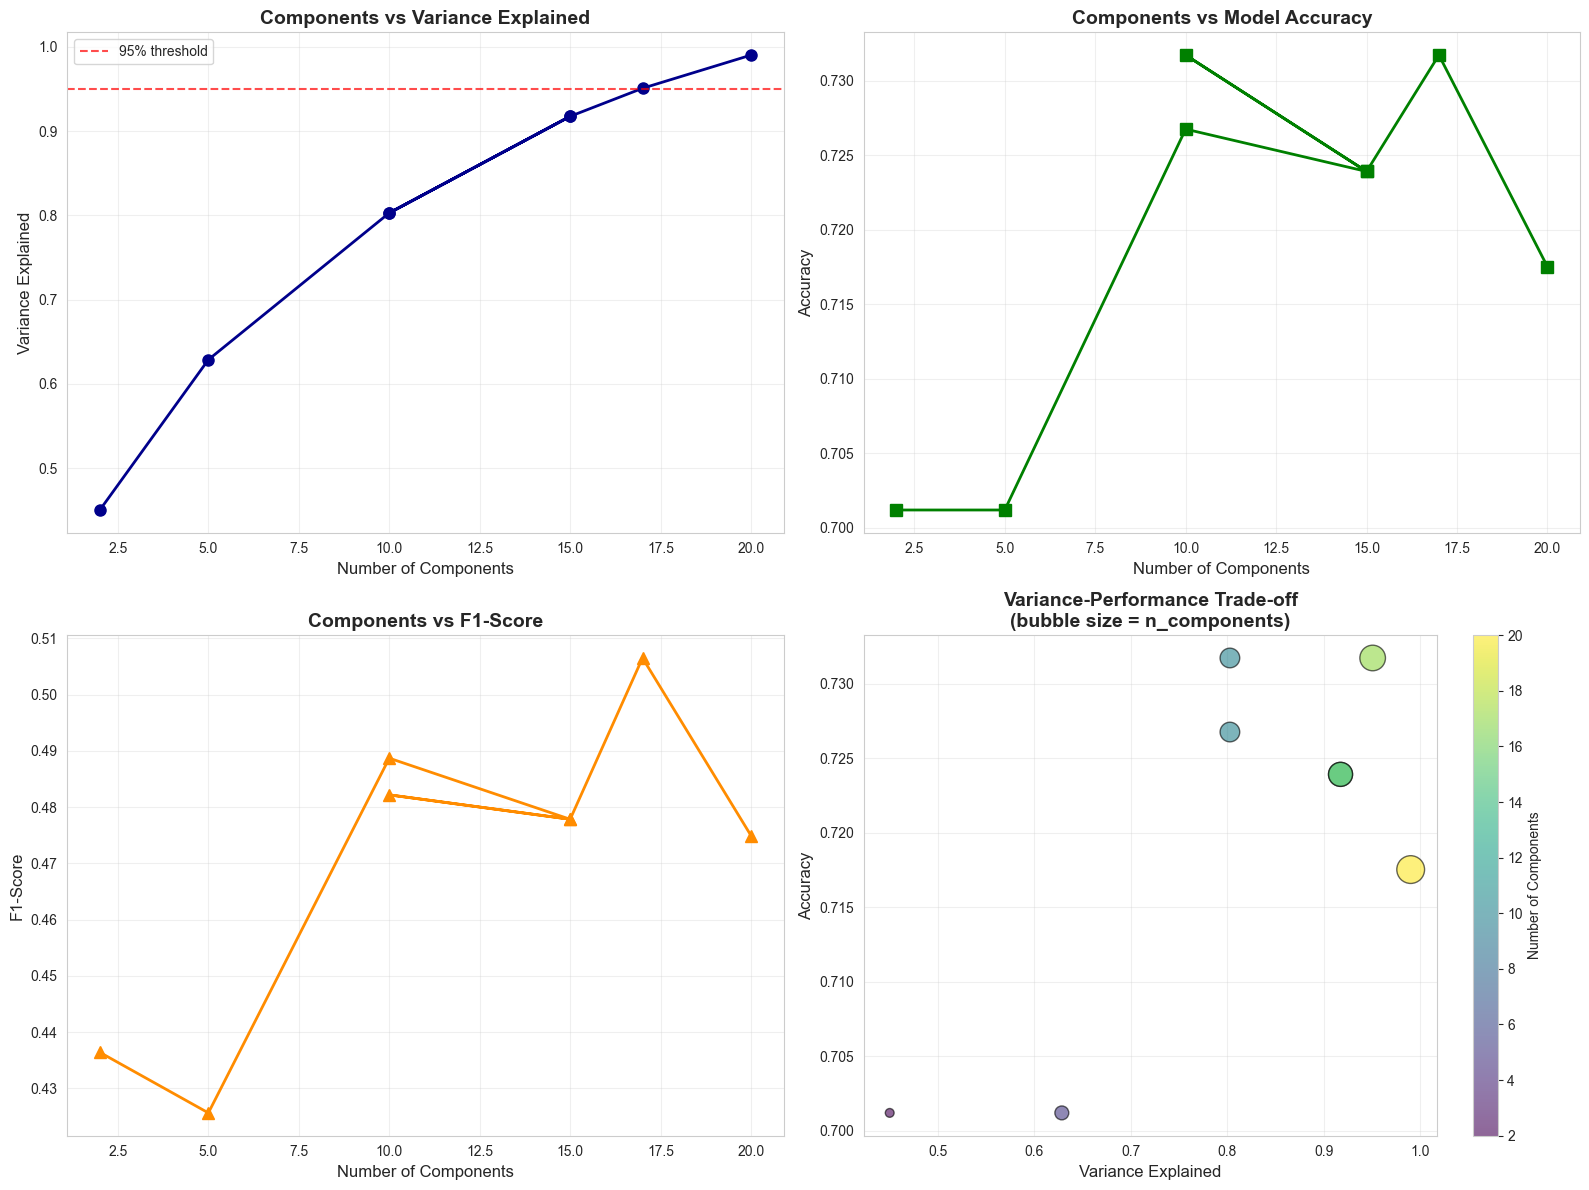


📊 OBSERVATIONS:
- More components retain more variance but may lead to overfitting
- There's a trade-off between dimensionality reduction and information retention
- Optimal balance is often around 90-95% variance explained


In [55]:
# Visualize n_components experiment results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Components vs Variance Explained
axes[0, 0].plot(df_n_components['actual_components'], 
                df_n_components['variance_explained'], 
                marker='o', linewidth=2, markersize=8, color='darkblue')
axes[0, 0].set_xlabel('Number of Components', fontsize=12)
axes[0, 0].set_ylabel('Variance Explained', fontsize=12)
axes[0, 0].set_title('Components vs Variance Explained', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% threshold')
axes[0, 0].legend()

# Plot 2: Components vs Accuracy
axes[0, 1].plot(df_n_components['actual_components'], 
                df_n_components['accuracy'], 
                marker='s', linewidth=2, markersize=8, color='green')
axes[0, 1].set_xlabel('Number of Components', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Components vs Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Components vs F1-Score
axes[1, 0].plot(df_n_components['actual_components'], 
                df_n_components['f1_score'], 
                marker='^', linewidth=2, markersize=8, color='darkorange')
axes[1, 0].set_xlabel('Number of Components', fontsize=12)
axes[1, 0].set_ylabel('F1-Score', fontsize=12)
axes[1, 0].set_title('Components vs F1-Score', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Variance vs Performance Trade-off
axes[1, 1].scatter(df_n_components['variance_explained'], 
                   df_n_components['accuracy'], 
                   s=df_n_components['actual_components']*20, 
                   alpha=0.6, c=df_n_components['actual_components'], 
                   cmap='viridis', edgecolors='black', linewidth=1)
axes[1, 1].set_xlabel('Variance Explained', fontsize=12)
axes[1, 1].set_ylabel('Accuracy', fontsize=12)
axes[1, 1].set_title('Variance-Performance Trade-off\n(bubble size = n_components)', 
                     fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Number of Components', fontsize=10)

plt.tight_layout()
plt.show()

print("\n📊 OBSERVATIONS:")
print("- More components retain more variance but may lead to overfitting")
print("- There's a trade-off between dimensionality reduction and information retention")
print("- Optimal balance is often around 90-95% variance explained")

### 8.2 Experiment with svd_solver Parameter

In [ ]:
"""
EXPERIMENT 2: svd_solver Parameter
================================

"""

import time

# Test different svd_solver options
svd_solvers = ['auto', 'full', 'randomized']  # 'arpack' requires n_components < n_features
results_svd = []

print("=" * 80)
print("EXPERIMENT 2: Testing svd_solver Parameter")
print("=" * 80)

n_comp_test = 15  # Use fixed number of components for fair comparison

for solver in svd_solvers:
    try:
        # Measure computation time
        start_time = time.time()
        
        # Apply PCA
        pca_solver = PCA(n_components=n_comp_test, svd_solver=solver, random_state=52)
        X_train_solver = pca_solver.fit_transform(X_train)
        X_test_solver = pca_solver.transform(X_test)
        
        fit_time = time.time() - start_time
        
        # Train Decision Tree
        dt_solver = DecisionTreeClassifier(random_state=52)
        dt_solver.fit(X_train_solver, y_train)
        y_pred_solver = dt_solver.predict(X_test_solver)
        
        # Calculate metrics
        acc = accuracy_score(y_test, y_pred_solver)
        f1 = f1_score(y_test, y_pred_solver)
        variance_explained = pca_solver.explained_variance_ratio_.sum()
        
        results_svd.append({
            'svd_solver': solver,
            'fit_time_ms': fit_time * 1000,  # Convert to milliseconds
            'variance_explained': variance_explained,
            'accuracy': acc,
            'f1_score': f1
        })
        
        print(f"\nsvd_solver='{solver}':")
        print(f"  Fit time: {fit_time*1000:.2f} ms")
        print(f"  Variance explained: {variance_explained:.4f}")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        
    except Exception as e:
        print(f"\nsvd_solver='{solver}': Error - {str(e)}")

print("\n" + "=" * 80)

# Convert to DataFrame
df_svd = pd.DataFrame(results_svd)
print("\nSummary Table:")
print(df_svd.to_string(index=False))

EXPERIMENT 2: Testing svd_solver Parameter

svd_solver='auto':
  Fit time: 31.92 ms
  Variance explained: 0.9174
  Accuracy: 0.7239
  F1-Score: 0.4779

svd_solver='full':
  Fit time: 17.88 ms
  Variance explained: 0.9174
  Accuracy: 0.7239
  F1-Score: 0.4779

svd_solver='randomized':
  Fit time: 37.12 ms
  Variance explained: 0.9174
  Accuracy: 0.7239
  F1-Score: 0.4779


Summary Table:
svd_solver  fit_time_ms  variance_explained  accuracy  f1_score
      auto    31.917334            0.917423  0.723918  0.477852
      full    17.878771            0.917423  0.723918  0.477852
randomized    37.121773            0.917423  0.723918  0.477852


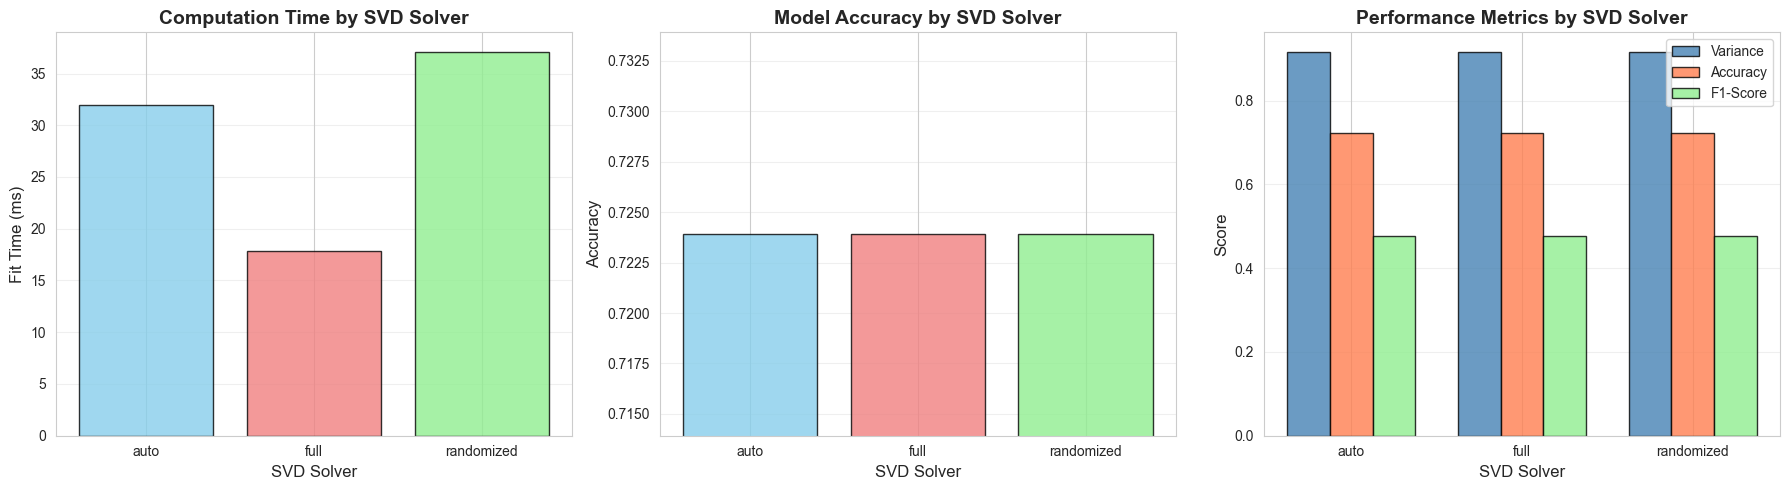


📊 OBSERVATIONS:
- All solvers produce nearly identical accuracy (numerical stability)


In [66]:
# Visualize svd_solver experiment results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Computation Time
axes[0].bar(df_svd['svd_solver'], df_svd['fit_time_ms'], 
            color=['skyblue', 'lightcoral', 'lightgreen'], 
            edgecolor='black', alpha=0.8)
axes[0].set_xlabel('SVD Solver', fontsize=12)
axes[0].set_ylabel('Fit Time (ms)', fontsize=12)
axes[0].set_title('Computation Time by SVD Solver', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Accuracy Comparison
axes[1].bar(df_svd['svd_solver'], df_svd['accuracy'], 
            color=['skyblue', 'lightcoral', 'lightgreen'], 
            edgecolor='black', alpha=0.8)
axes[1].set_xlabel('SVD Solver', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Model Accuracy by SVD Solver', fontsize=14, fontweight='bold')
axes[1].set_ylim([df_svd['accuracy'].min() - 0.01, df_svd['accuracy'].max() + 0.01])
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Performance Summary
x = np.arange(len(df_svd))
width = 0.25

axes[2].bar(x - width, df_svd['variance_explained'], width, 
            label='Variance', alpha=0.8, color='steelblue', edgecolor='black')
axes[2].bar(x, df_svd['accuracy'], width, 
            label='Accuracy', alpha=0.8, color='coral', edgecolor='black')
axes[2].bar(x + width, df_svd['f1_score'], width, 
            label='F1-Score', alpha=0.8, color='lightgreen', edgecolor='black')
axes[2].set_xlabel('SVD Solver', fontsize=12)
axes[2].set_ylabel('Score', fontsize=12)
axes[2].set_title('Performance Metrics by SVD Solver', fontsize=14, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(df_svd['svd_solver'])
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 OBSERVATIONS:")
print("- All solvers produce nearly identical accuracy (numerical stability)")

### 8.3 Experiment with whiten Parameter

In [58]:
"""
EXPERIMENT 3: whiten Parameter
===============================
When True, the components are divided by sqrt(n_samples) * singular_values
This ensures that the transformed features have unit variance (are uncorrelated).

Benefits of whitening:
- Components become uncorrelated with unit variance
- Can improve performance of some algorithms (e.g., neural networks)
- Removes scaling differences between components

Impact: Normalizes the principal components
"""

# Test with and without whitening
whiten_options = [False, True]
results_whiten = []

print("=" * 80)
print("EXPERIMENT 3: Testing whiten Parameter")
print("=" * 80)

for whiten_val in whiten_options:
    # Apply PCA
    pca_whiten = PCA(n_components=15, whiten=whiten_val, random_state=52)
    X_train_whiten = pca_whiten.fit_transform(X_train)
    X_test_whiten = pca_whiten.transform(X_test)
    
    # Analyze transformed data statistics
    mean_vals = np.mean(X_train_whiten, axis=0)
    std_vals = np.std(X_train_whiten, axis=0)
    
    # Train Decision Tree
    dt_whiten = DecisionTreeClassifier(random_state=52)
    dt_whiten.fit(X_train_whiten, y_train)
    y_pred_whiten = dt_whiten.predict(X_test_whiten)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred_whiten)
    prec = precision_score(y_test, y_pred_whiten)
    rec = recall_score(y_test, y_pred_whiten)
    f1 = f1_score(y_test, y_pred_whiten)
    
    results_whiten.append({
        'whiten': whiten_val,
        'mean_of_means': np.mean(mean_vals),
        'mean_of_stds': np.mean(std_vals),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })
    
    print(f"\nwhiten={whiten_val}:")
    print(f"  Mean of component means: {np.mean(mean_vals):.6f}")
    print(f"  Mean of component stds: {np.mean(std_vals):.6f}")
    print(f"  Component std range: [{std_vals.min():.4f}, {std_vals.max():.4f}]")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  F1-Score: {f1:.4f}")

print("\n" + "=" * 80)

# Convert to DataFrame
df_whiten = pd.DataFrame(results_whiten)
print("\nSummary Table:")
print(df_whiten.to_string(index=False))

EXPERIMENT 3: Testing whiten Parameter

whiten=False:
  Mean of component means: 0.000000
  Mean of component stds: 1.213262
  Component std range: [0.7828, 3.1388]
  Accuracy: 0.7239
  Precision: 0.4798
  Recall: 0.4759
  F1-Score: 0.4779

whiten=True:
  Mean of component means: 0.000000
  Mean of component stds: 0.999911
  Component std range: [0.9999, 0.9999]
  Accuracy: 0.7239
  Precision: 0.4798
  Recall: 0.4759
  F1-Score: 0.4779


Summary Table:
 whiten  mean_of_means  mean_of_stds  accuracy  precision   recall  f1_score
  False   1.949663e-16      1.213262  0.723918   0.479784 0.475936  0.477852
   True   1.434143e-16      0.999911  0.723918   0.479784 0.475936  0.477852


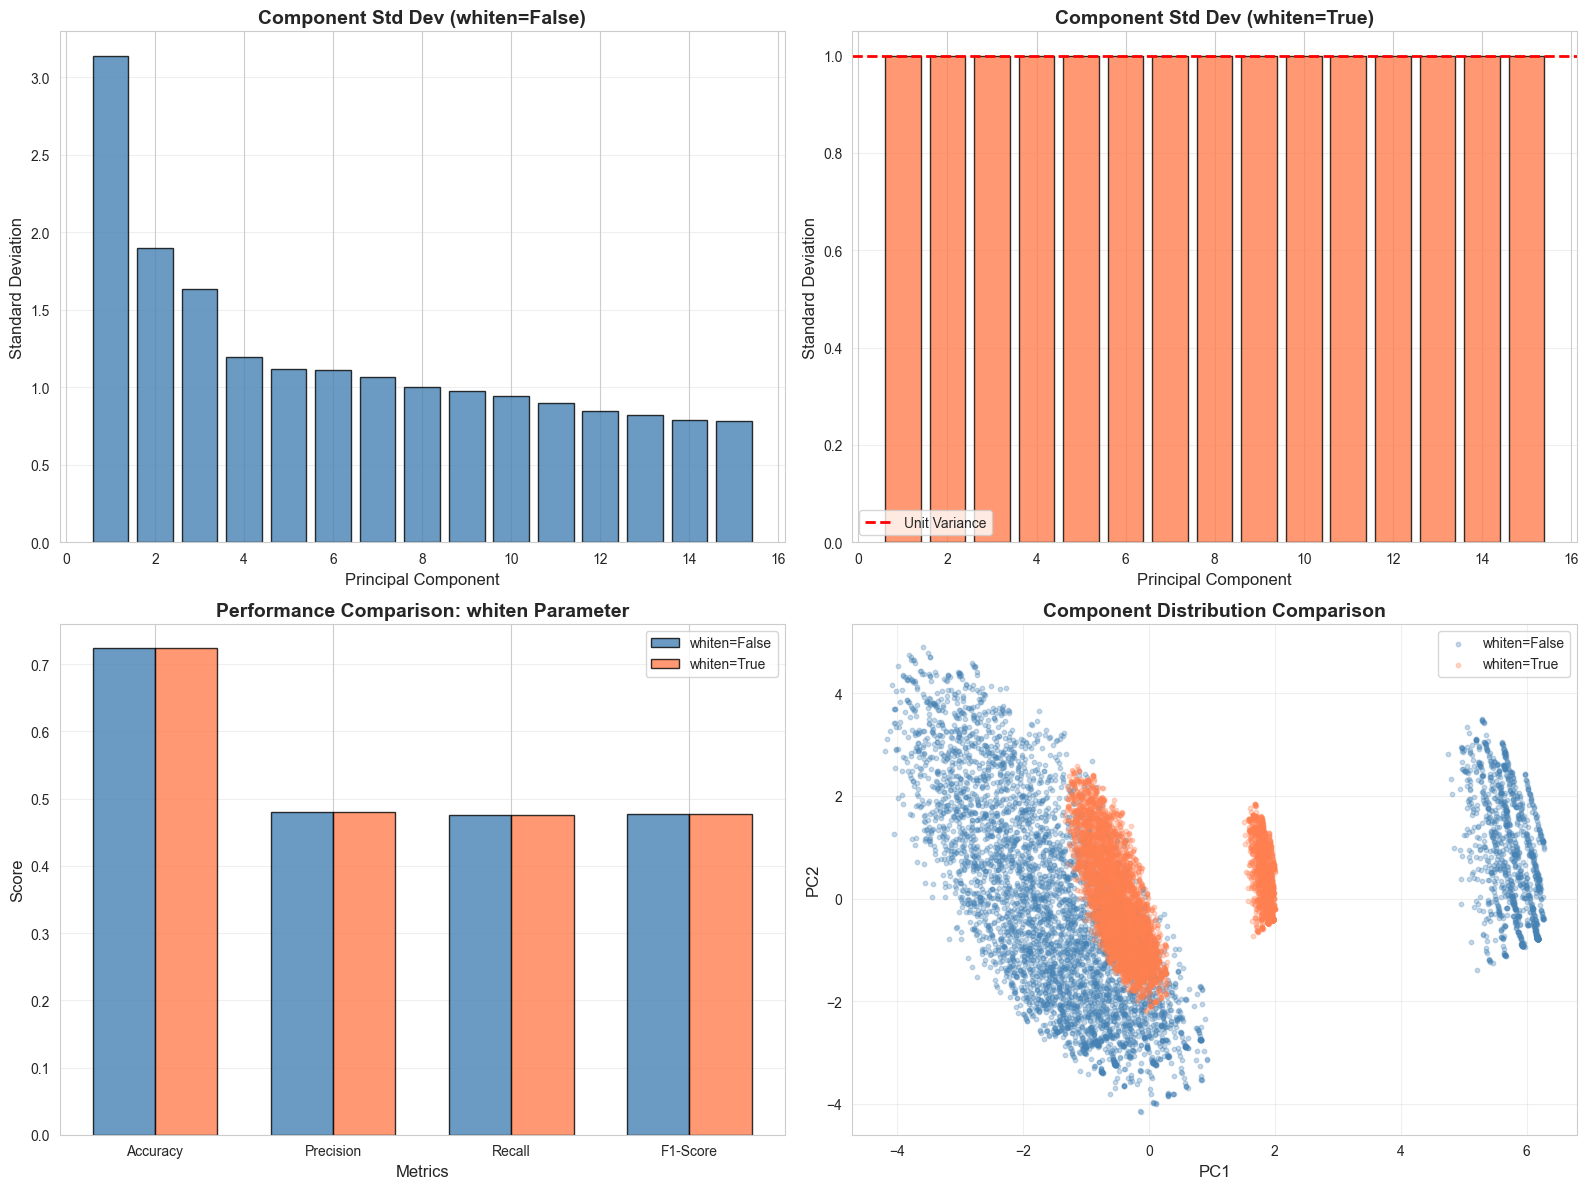


📊 OBSERVATIONS:
- Without whitening: Components have varying scales based on explained variance
- With whitening: All components normalized to unit variance
- Whitening is useful when you want equal weight for all principal components
- For Decision Trees, whitening has minimal impact (tree-based models are scale-invariant)


In [59]:
# Visualize whiten parameter effects
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get data for detailed visualization
pca_no_whiten = PCA(n_components=15, whiten=False, random_state=52)
X_train_no_whiten = pca_no_whiten.fit_transform(X_train)

pca_with_whiten = PCA(n_components=15, whiten=True, random_state=52)
X_train_with_whiten = pca_with_whiten.fit_transform(X_train)

# Plot 1: Standard Deviations of Components (No Whitening)
axes[0, 0].bar(range(1, 16), np.std(X_train_no_whiten, axis=0), 
               color='steelblue', edgecolor='black', alpha=0.8)
axes[0, 0].set_xlabel('Principal Component', fontsize=12)
axes[0, 0].set_ylabel('Standard Deviation', fontsize=12)
axes[0, 0].set_title('Component Std Dev (whiten=False)', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Standard Deviations of Components (With Whitening)
axes[0, 1].bar(range(1, 16), np.std(X_train_with_whiten, axis=0), 
               color='coral', edgecolor='black', alpha=0.8)
axes[0, 1].set_xlabel('Principal Component', fontsize=12)
axes[0, 1].set_ylabel('Standard Deviation', fontsize=12)
axes[0, 1].set_title('Component Std Dev (whiten=True)', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Unit Variance')
axes[0, 1].legend()

# Plot 3: Performance Metrics Comparison
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
x = np.arange(len(metrics))
width = 0.35

no_whiten_vals = [df_whiten.loc[0, m] for m in metrics]
with_whiten_vals = [df_whiten.loc[1, m] for m in metrics]

axes[1, 0].bar(x - width/2, no_whiten_vals, width, 
               label='whiten=False', alpha=0.8, color='steelblue', edgecolor='black')
axes[1, 0].bar(x + width/2, with_whiten_vals, width, 
               label='whiten=True', alpha=0.8, color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Metrics', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Performance Comparison: whiten Parameter', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Distribution of First Two Components
axes[1, 1].scatter(X_train_no_whiten[:, 0], X_train_no_whiten[:, 1], 
                   alpha=0.3, s=10, c='steelblue', label='whiten=False')
axes[1, 1].scatter(X_train_with_whiten[:, 0], X_train_with_whiten[:, 1], 
                   alpha=0.3, s=10, c='coral', label='whiten=True')
axes[1, 1].set_xlabel('PC1', fontsize=12)
axes[1, 1].set_ylabel('PC2', fontsize=12)
axes[1, 1].set_title('Component Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 OBSERVATIONS:")
print("- Without whitening: Components have varying scales based on explained variance")
print("- With whitening: All components normalized to unit variance")
print("- Whitening is useful when you want equal weight for all principal components")
print("- For Decision Trees, whitening has minimal impact (tree-based models are scale-invariant)")

## Step 9: Advanced PCA Visualizations

### 9.1 Scree Plot - Explained Variance Ratio

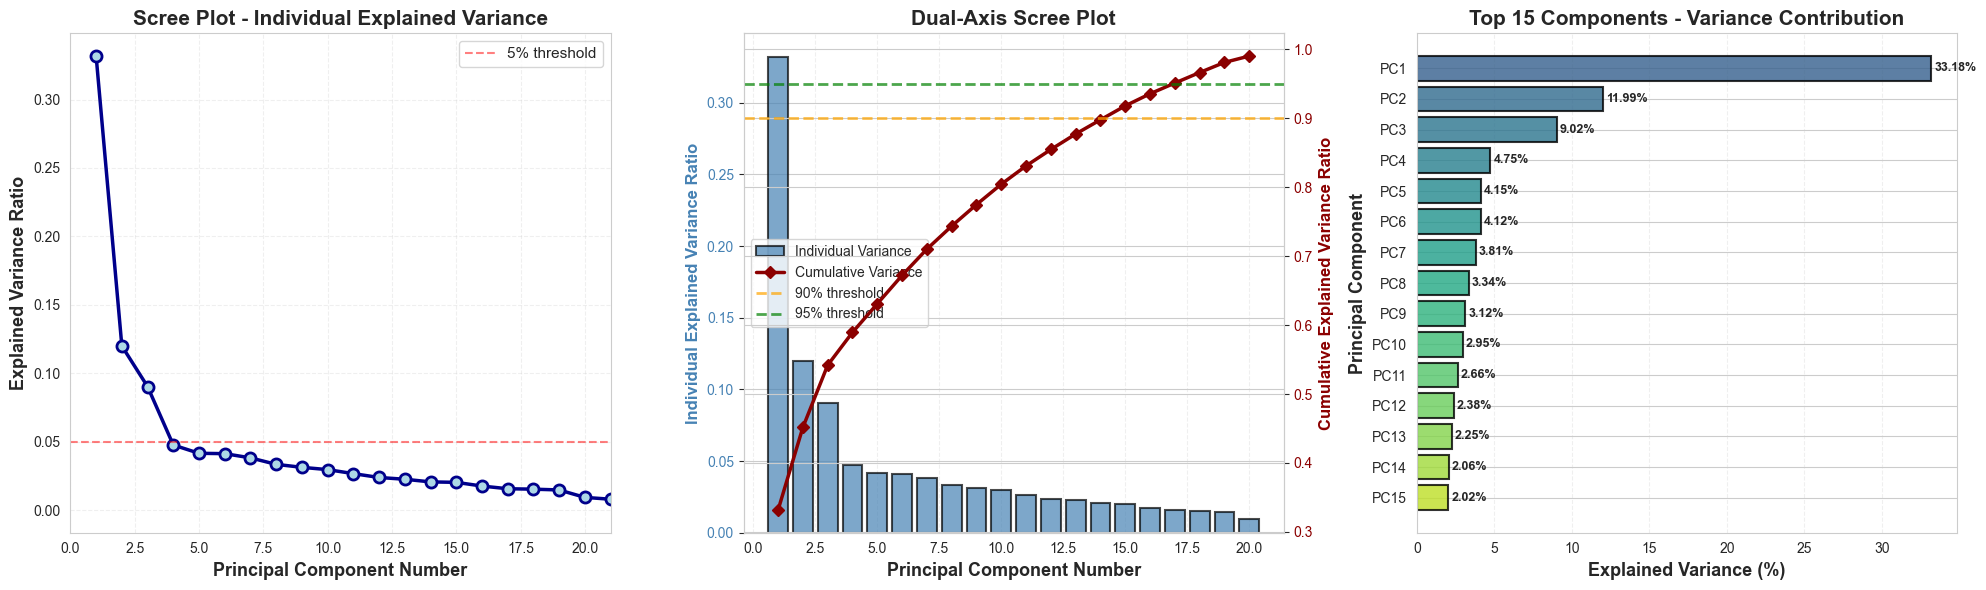

SCREE PLOT ANALYSIS SUMMARY
Total components: 30
Top component explains: 33.18% of variance
Top 5 components explain: 63.08% of variance
Top 10 components explain: 80.43% of variance

Elbow point (< 5.0% variance): Component 4


In [60]:
# Create comprehensive scree plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Classic Scree Plot (Line Plot)
axes[0].plot(range(1, len(explained_variance_ratio)+1), 
             explained_variance_ratio, 
             marker='o', linewidth=2.5, markersize=8, color='darkblue', 
             markerfacecolor='lightblue', markeredgecolor='darkblue', markeredgewidth=2)
axes[0].set_xlabel('Principal Component Number', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=13, fontweight='bold')
axes[0].set_title('Scree Plot - Individual Explained Variance', fontsize=15, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='5% threshold')
axes[0].legend(fontsize=11)

# Add elbow annotation
max_components_show = min(20, len(explained_variance_ratio))
axes[0].set_xlim(0, max_components_show + 1)

# Plot 2: Bar Chart with Cumulative Line
ax2_twin = axes[1].twinx()
bars = axes[1].bar(range(1, max_components_show+1), 
                   explained_variance_ratio[:max_components_show], 
                   alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5,
                   label='Individual Variance')
line = ax2_twin.plot(range(1, max_components_show+1), 
                     cumulative_variance_ratio[:max_components_show], 
                     color='darkred', marker='D', linewidth=2.5, markersize=6,
                     label='Cumulative Variance')

axes[1].set_xlabel('Principal Component Number', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Individual Explained Variance Ratio', fontsize=12, fontweight='bold', color='steelblue')
ax2_twin.set_ylabel('Cumulative Explained Variance Ratio', fontsize=12, fontweight='bold', color='darkred')
axes[1].set_title('Dual-Axis Scree Plot', fontsize=15, fontweight='bold')
axes[1].tick_params(axis='y', labelcolor='steelblue')
ax2_twin.tick_params(axis='y', labelcolor='darkred')
axes[1].grid(True, alpha=0.3, linestyle='--', axis='x')

# Add threshold lines
ax2_twin.axhline(y=0.90, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='90% threshold')
ax2_twin.axhline(y=0.95, color='green', linestyle='--', linewidth=2, alpha=0.7, label='95% threshold')

# Combine legends
lines1, labels1 = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
axes[1].legend(lines1 + lines2, labels1 + labels2, loc='center left', fontsize=10)

# Plot 3: Percentage Explained with Annotations
components_to_show = min(15, len(explained_variance_ratio))
bars3 = axes[2].barh(range(components_to_show, 0, -1), 
                     explained_variance_ratio[:components_to_show] * 100, 
                     alpha=0.8, color=plt.cm.viridis(np.linspace(0.3, 0.9, components_to_show)),
                     edgecolor='black', linewidth=1.5)

# Add percentage labels on bars
for i, (bar, val) in enumerate(zip(bars3, explained_variance_ratio[:components_to_show] * 100)):
    axes[2].text(val + 0.2, bar.get_y() + bar.get_height()/2, 
                f'{val:.2f}%', va='center', fontsize=9, fontweight='bold')

axes[2].set_ylabel('Principal Component', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Explained Variance (%)', fontsize=13, fontweight='bold')
axes[2].set_title(f'Top {components_to_show} Components - Variance Contribution', 
                 fontsize=15, fontweight='bold')
axes[2].grid(True, alpha=0.3, linestyle='--', axis='x')
axes[2].set_yticks(range(components_to_show, 0, -1))
axes[2].set_yticklabels([f'PC{i}' for i in range(1, components_to_show+1)])

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 80)
print("SCREE PLOT ANALYSIS SUMMARY")
print("=" * 80)
print(f"Total components: {len(explained_variance_ratio)}")
print(f"Top component explains: {explained_variance_ratio[0]*100:.2f}% of variance")
print(f"Top 5 components explain: {cumulative_variance_ratio[4]*100:.2f}% of variance")
print(f"Top 10 components explain: {cumulative_variance_ratio[9]*100:.2f}% of variance")

# Find elbow point (where variance drops below certain threshold)
elbow_threshold = 0.05
elbow_point = np.argmax(explained_variance_ratio < elbow_threshold) + 1
print(f"\nElbow point (< {elbow_threshold*100}% variance): Component {elbow_point}")
print("=" * 80)

### 9.2 Heatmap of Component Loadings

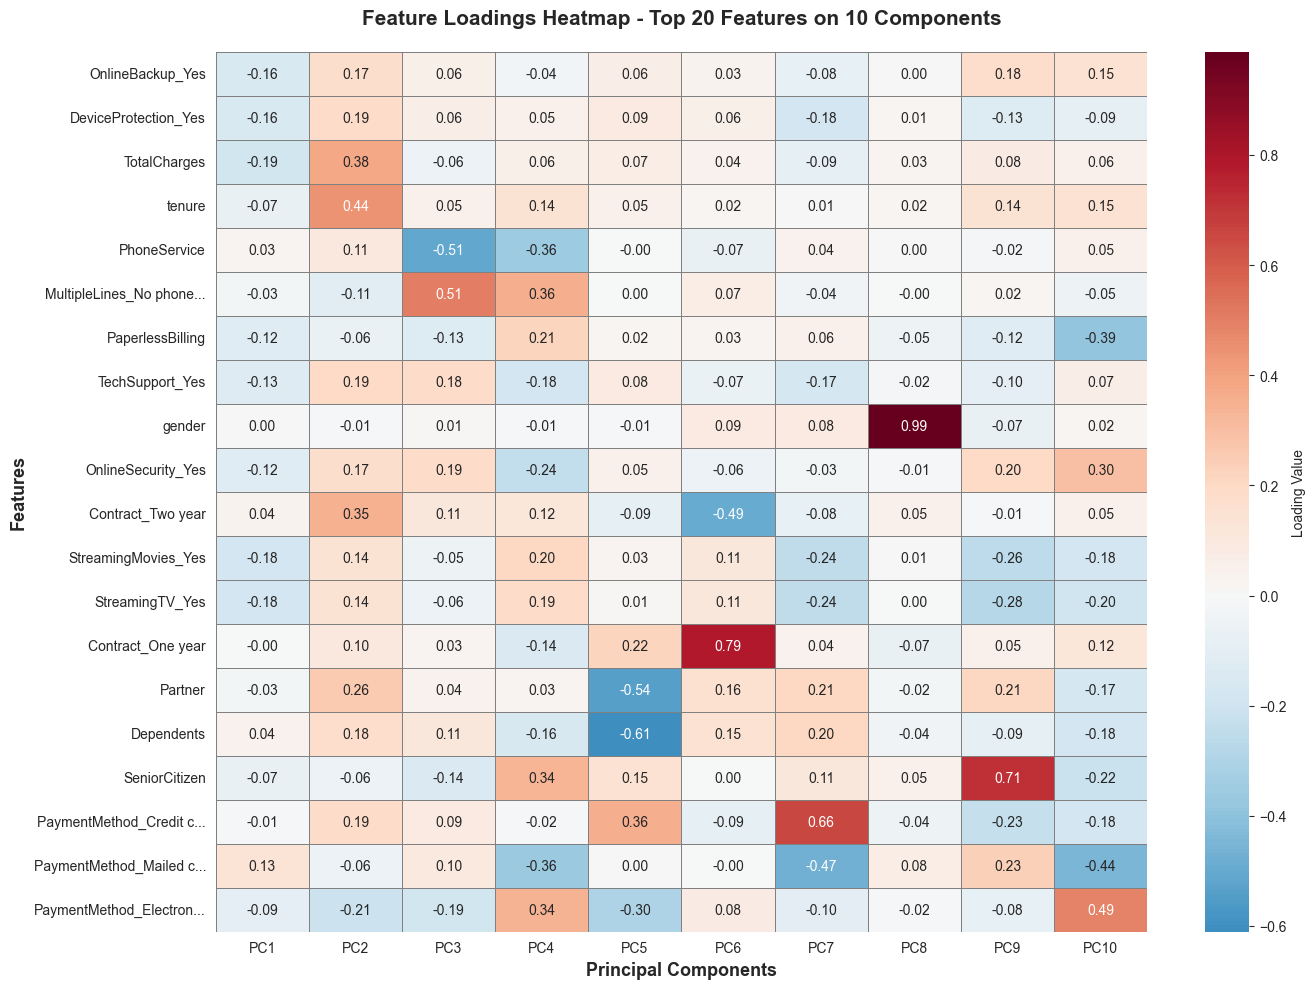

LOADING HEATMAP INTERPRETATION
🔴 Red (Positive): Feature positively contributes to the component
🔵 Blue (Negative): Feature negatively contributes to the component
⚪ White (Near Zero): Feature has little influence on the component

Top 5 Most Influential Features Overall:
  1. PaymentMethod_Electronic check: 1.9153
  2. PaymentMethod_Mailed check: 1.8753
  3. PaymentMethod_Credit card (automatic): 1.8746
  4. SeniorCitizen: 1.8503
  5. Dependents: 1.7648


In [64]:
# Create heatmap of feature loadings for principal components
n_components_show = min(10, pca.n_components_)
n_features_show = min(20, len(X.columns))

# Get the most important features based on their total loading across top components
feature_importance = np.abs(pca.components_[:n_components_show, :]).sum(axis=0)
top_features_idx = np.argsort(feature_importance)[-n_features_show:]

# Create loading matrix for visualization
loading_matrix = pca.components_[:n_components_show, top_features_idx].T

# Create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(loading_matrix, 
            cmap='RdBu_r', 
            center=0,
            annot=True, 
            fmt='.2f',
            cbar_kws={'label': 'Loading Value'},
            xticklabels=[f'PC{i+1}' for i in range(n_components_show)],
            yticklabels=[X.columns[i] if len(X.columns[i]) <= 25 else X.columns[i][:22]+'...' 
                        for i in top_features_idx],
            linewidths=0.5,
            linecolor='gray')

plt.title(f'Feature Loadings Heatmap - Top {n_features_show} Features on {n_components_show} Components', 
         fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Principal Components', fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("=" * 80)
print("LOADING HEATMAP INTERPRETATION")
print("=" * 80)
print("🔴 Red (Positive): Feature positively contributes to the component")
print("🔵 Blue (Negative): Feature negatively contributes to the component")
print("⚪ White (Near Zero): Feature has little influence on the component")
print("\nTop 5 Most Influential Features Overall:")
top5_overall = np.argsort(feature_importance)[-5:][::-1]
for rank, idx in enumerate(top5_overall, 1):
    print(f"  {rank}. {X.columns[idx]}: {feature_importance[idx]:.4f}")
print("=" * 80)